In [1]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_train/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(1, 2048)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sklearn; print(sklearn.__version__)

1.2.2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
with open('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [6]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape


37081
7621


(tensor(4.8656), torch.Size([]))

In [7]:
pos_weight

tensor(4.8656)

In [12]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_audio.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float()

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,2055), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [13]:
input_size = 2055
hidden_size = 2048
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 4
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).float()) 

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp-cause-pair/models/pair_detection_model_late_audio.pt')

/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1966
Epoch [1/20], Batch [10/17], Loss: 1.1656
Epoch [1/20], Batch [15/17], Loss: 1.1229
Epoch 1/20, Loss: 1.1909
Epoch [2/20], Batch [5/17], Loss: 1.0625
Epoch [2/20], Batch [10/17], Loss: 1.1039
Epoch [2/20], Batch [15/17], Loss: 1.1263
Epoch 2/20, Loss: 1.1150
Epoch [3/20], Batch [5/17], Loss: 1.1576
Epoch [3/20], Batch [10/17], Loss: 1.1098
Epoch [3/20], Batch [15/17], Loss: 1.1463
Epoch 3/20, Loss: 1.1011
Epoch [4/20], Batch [5/17], Loss: 1.0971
Epoch [4/20], Batch [10/17], Loss: 1.1052
Epoch [4/20], Batch [15/17], Loss: 1.1242
Epoch 4/20, Loss: 1.0943
Epoch [5/20], Batch [5/17], Loss: 1.0922
Epoch [5/20], Batch [10/17], Loss: 1.0553
Epoch [5/20], Batch [15/17], Loss: 1.1137
Epoch 5/20, Loss: 1.0847
Epoch [6/20], Batch [5/17], Loss: 1.1518
Epoch [6/20], Batch [10/17], Loss: 1.1319
Epoch [6/20], Batch [15/17], Loss: 1.0319
Epoch 6/20, Loss: 1.0771
Epoch [7/20], Batch [5/17], Loss: 0.9889
Epoch [7/20], Batch [10/17], Loss: 1.0303
Epoch [7/20], Bat

In [14]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels


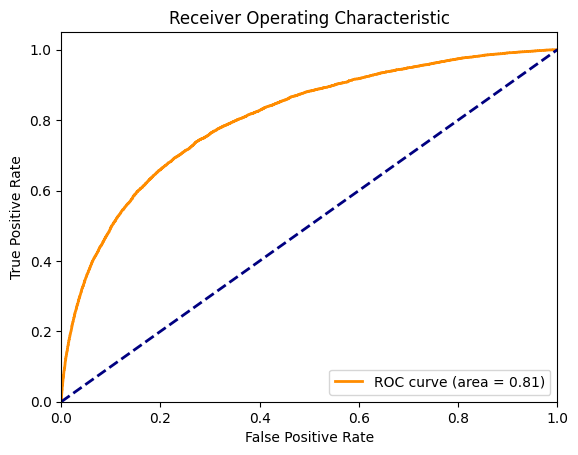

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_train'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.49184367060661316


In [17]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [22]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predictions = {}
    detailed_results = {}  # Initialize the dictionary at the beginning of the function
    correct_pair = 0
    combined_TP = 0
    combined_FP = 0
    combined_FN = 0
    combined_TN = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_all.json')


    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()

            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            prediction_tensor = binary_predictions
            true_tensor = active_pairs
            pair_flag = -1
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        correct_pair +=1
                    if (match and true_tensor[pair_flag]==1 and prediction_tensor[pair_flag]==1):
                        combined_TP +=1
                    elif (match and prediction_tensor[pair_flag]==1 and true_tensor[pair_flag]==0):
                        combined_FP +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==1):
                        combined_FN +=1
                    elif (match and prediction_tensor[pair_flag]==0 and true_tensor[pair_flag]==0):
                        combined_TN +=1
            
            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    print(f"Combined True Positives: {combined_TP}")
    print(f"Combined False Positives: {combined_FP}")
    print(f"Combined False Negatives: {combined_FN}")
    print(f"Combined True Negatives: {combined_TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    combined_accuracy = correct_pair/total_samples   
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    combined_precision = combined_TP / (combined_TP + combined_FP) if (combined_TP + combined_FP) > 0 else 0
    combined_recall = combined_TP / (combined_TP + combined_FN) if (combined_TP + combined_FN) > 0 else 0
    combined_f1_score = 2 * (combined_precision * combined_recall) / (combined_precision + combined_recall) if (combined_precision + combined_recall) > 0 else 0

    print(f"Combined Precision: {combined_precision:.4f}, Combined Recall: {combined_recall:.4f}, Combined F1-Score: {combined_f1_score:.4f}")

    return average_loss, accuracy, precision, recall, f1_score, combined_accuracy

In [23]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score,val_accuracy = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}, Combined Accuracy: {val_accuracy:.4f}')

True Positives: 1402
False Positives: 3488
False Negatives: 391
True Negatives: 5051
Total samples: 10332
Combined True Positives: 309
Combined False Positives: 743
Combined False Negatives: 77
Combined True Negatives: 820
Total samples: 10332
Combined Precision: 0.2937, Combined Recall: 0.8005, Combined F1-Score: 0.4298
Test Loss: 1.0135, Test Accuracy: 0.1093, Precision: 0.2867, Recall: 0.7819, F1 Score: 0.4196, Combined Accuracy: 0.1093


For pos_w: 4.8


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.4240
Epoch [1/20], Batch [10/17], Loss: 1.2478
Epoch [1/20], Batch [15/17], Loss: 1.1774
Epoch 1/20, Loss: 1.3039
Epoch [2/20], Batch [5/17], Loss: 1.1296
Epoch [2/20], Batch [10/17], Loss: 1.1633
Epoch [2/20], Batch [15/17], Loss: 1.1080
Epoch 2/20, Loss: 1.1351
Epoch [3/20], Batch [5/17], Loss: 1.0974
Epoch [3/20], Batch [10/17], Loss: 1.1081
Epoch [3/20], Batch [15/17], Loss: 1.0978
Epoch 3/20, Loss: 1.1061
Epoch [4/20], Batch [5/17], Loss: 1.1342
Epoch [4/20], Batch [10/17], Loss: 1.0815
Epoch [4/20], Batch [15/17], Loss: 1.0687
Epoch 4/20, Loss: 1.0964
Epoch [5/20], Batch [5/17], Loss: 1.0482
Epoch [5/20], Batch [10/17], Loss: 1.1002
Epoch [5/20], Batch [15/17], Loss: 1.0993
Epoch 5/20, Loss: 1.0802
Epoch [6/20], Batch [5/17], Loss: 1.1277
Epoch [6/20], Batch [10/17], Loss: 1.1140
Epoch [6/20], Batch [15/17], Loss: 1.0049
Epoch 6/20, Loss: 1.0816
Epoch [7/20], Batch [5/17], Loss: 1.1324
Epoch [7/20], Batch [10/17], Loss: 1.0393
Epoch [7/20], Bat

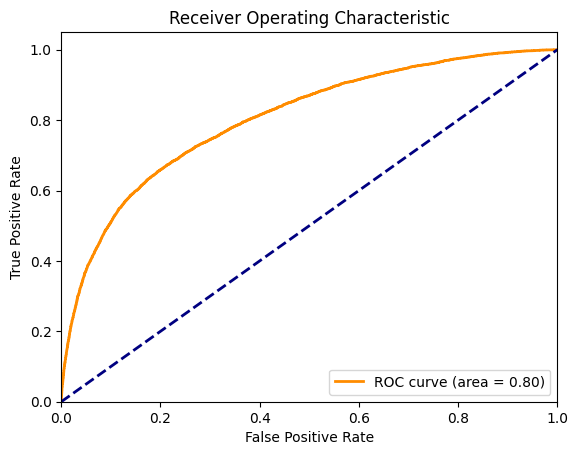

Optimal threshold: 0.5329576730728149
True Positives: 1320
False Positives: 2943
False Negatives: 473
True Negatives: 5596
Total samples: 10332
For pos_weight: 4.8 ---> Test Loss: 0.9548, Test Accuracy: 0.6694, Precision: 0.3096, Recall: 0.7362, F1 Score: 0.4359
For pos_w: 4.7


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.7246
Epoch [1/20], Batch [10/17], Loss: 1.2881
Epoch [1/20], Batch [15/17], Loss: 1.1713
Epoch 1/20, Loss: 1.3404
Epoch [2/20], Batch [5/17], Loss: 1.0888
Epoch [2/20], Batch [10/17], Loss: 1.1385
Epoch [2/20], Batch [15/17], Loss: 1.1404
Epoch 2/20, Loss: 1.1084
Epoch [3/20], Batch [5/17], Loss: 1.0660
Epoch [3/20], Batch [10/17], Loss: 1.0883
Epoch [3/20], Batch [15/17], Loss: 1.1455
Epoch 3/20, Loss: 1.0902
Epoch [4/20], Batch [5/17], Loss: 1.0240
Epoch [4/20], Batch [10/17], Loss: 1.0508
Epoch [4/20], Batch [15/17], Loss: 1.1441
Epoch 4/20, Loss: 1.0795
Epoch [5/20], Batch [5/17], Loss: 1.0991
Epoch [5/20], Batch [10/17], Loss: 1.1650
Epoch [5/20], Batch [15/17], Loss: 1.0425
Epoch 5/20, Loss: 1.0706
Epoch [6/20], Batch [5/17], Loss: 1.1186
Epoch [6/20], Batch [10/17], Loss: 1.0304
Epoch [6/20], Batch [15/17], Loss: 1.0245
Epoch 6/20, Loss: 1.0617
Epoch [7/20], Batch [5/17], Loss: 1.0065
Epoch [7/20], Batch [10/17], Loss: 1.0323
Epoch [7/20], Bat

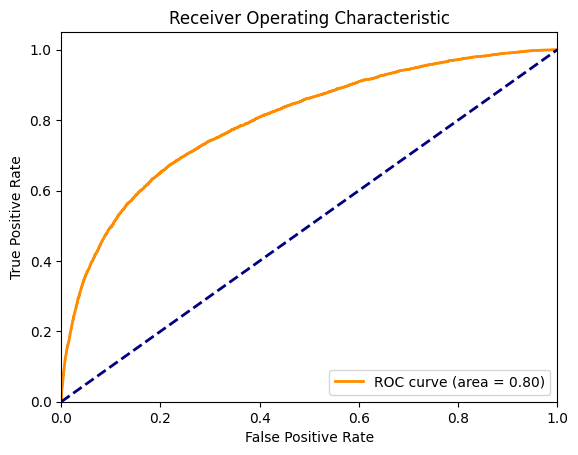

Optimal threshold: 0.5197091102600098
True Positives: 1315
False Positives: 2757
False Negatives: 478
True Negatives: 5782
Total samples: 10332
For pos_weight: 4.7 ---> Test Loss: 0.9384, Test Accuracy: 0.6869, Precision: 0.3229, Recall: 0.7334, F1 Score: 0.4484
For pos_w: 4.6


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.2269
Epoch [1/20], Batch [10/17], Loss: 1.2236
Epoch [1/20], Batch [15/17], Loss: 1.0991
Epoch 1/20, Loss: 1.2336
Epoch [2/20], Batch [5/17], Loss: 1.0643
Epoch [2/20], Batch [10/17], Loss: 1.1223
Epoch [2/20], Batch [15/17], Loss: 1.0709
Epoch 2/20, Loss: 1.1001
Epoch [3/20], Batch [5/17], Loss: 1.1074
Epoch [3/20], Batch [10/17], Loss: 1.0848
Epoch [3/20], Batch [15/17], Loss: 1.1076
Epoch 3/20, Loss: 1.0871
Epoch [4/20], Batch [5/17], Loss: 1.0866
Epoch [4/20], Batch [10/17], Loss: 1.0826
Epoch [4/20], Batch [15/17], Loss: 1.0893
Epoch 4/20, Loss: 1.0686
Epoch [5/20], Batch [5/17], Loss: 1.0458
Epoch [5/20], Batch [10/17], Loss: 1.0169
Epoch [5/20], Batch [15/17], Loss: 1.0223
Epoch 5/20, Loss: 1.0595
Epoch [6/20], Batch [5/17], Loss: 1.0309
Epoch [6/20], Batch [10/17], Loss: 1.0633
Epoch [6/20], Batch [15/17], Loss: 1.0119
Epoch 6/20, Loss: 1.0436
Epoch [7/20], Batch [5/17], Loss: 1.0625
Epoch [7/20], Batch [10/17], Loss: 1.0155
Epoch [7/20], Bat

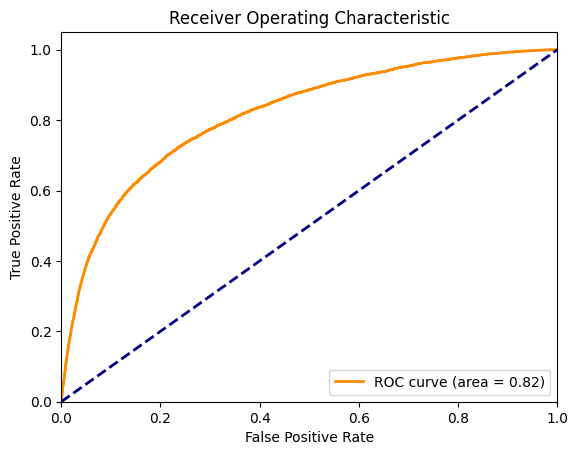

Optimal threshold: 0.35463130474090576
True Positives: 1515
False Positives: 3850
False Negatives: 278
True Negatives: 4689
Total samples: 10332
For pos_weight: 4.6 ---> Test Loss: 0.8866, Test Accuracy: 0.6005, Precision: 0.2824, Recall: 0.8450, F1 Score: 0.4233
For pos_w: 4.5


/project/msoleyma_1026/ecp-cause-pair/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1567
Epoch [1/20], Batch [10/17], Loss: 1.1009
Epoch [1/20], Batch [15/17], Loss: 1.1199
Epoch 1/20, Loss: 1.2090
Epoch [2/20], Batch [5/17], Loss: 1.0784


KeyboardInterrupt: 

In [20]:
pos_ws = [4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 2055
    hidden_size = 2048
    num_classes = 1
    lr = 2e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 4
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    torch.save(model.state_dict(), '/project/msoleyma_1026/ecp-cause-pair/models/pair_detection_model_late_audio.pt')

    
    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class PairDetectorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(PairDetectorMLP, self).__init__()
        self.mlp = MLP(input_dim, hidden_dim, num_classes)

    def forward(self, context_embeddings):
        return self.mlp(context_embeddings)

input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-3
batch_size = 64
num_epochs = 1
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetectorMLP(input_size, hidden_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_text.pt')

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch

            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            loss = criterion(output, target_pairs)

            total_loss += loss.item()
            total_samples += target_pairs.size(0)

    average_loss = total_loss / len(dataloader)

    return average_loss

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

val_loss = evaluate_model(model, test_dataloader, criterion)
print(f'Validation Loss: {val_loss:.4f}')

Error loading item 896: Embedding file not found for conv_1296_utterance_pair_1_1.npy


FileNotFoundError: Embedding file not found for conv_1296_utterance_pair_1_1.npy

In [15]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [16]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predictions = {}
    detailed_results = {}  # Initialize the dictionary at the beginning of the function
    correct_pair = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
    # Encode emotions
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    # Load predicted emotions
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_audio.json')


    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader):
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            #print(f"Batch {batch_index} - context_embeddings shape: {context_embeddings.shape}")
            #print(f"Batch {batch_index} - target_pairs shape before squeeze: {target_pairs.shape}")
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)
            #print(f"Batch {batch_index} - Model output: {output.tolist()}")  # Printing the raw model output
            #print(f"Batch {batch_index} - Model output shape: {output.shape}")

            target_pairs = target_pairs.squeeze()
            #print(f"Batch {batch_index} - Target pairs (after squeeze): {target_pairs.tolist()}")  # Print all target pairs
            #print(f"Batch {batch_index} - target_pairs shape after squeeze: {target_pairs.shape}")

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            #print(f"Batch {batch_index} - Active outputs: {active_outputs.tolist()}")  # Active model outputs
            #print(f"Batch {batch_index} - Active pairs: {active_pairs.tolist()}")  # Active target pairs
            #print(f"Batch {batch_index} - Active outputs shape: {active_outputs.shape}")
            #print(f"Batch {batch_index} - Active pairs shape: {active_pairs.shape}")

            loss = criterion(active_outputs, active_pairs)
            total_loss += loss.item()
            #print(f"Batch {batch_index} - Loss: {loss.item()}")

            sigmoid_output = torch.sigmoid(output)
            #print(f"Batch {batch_index} - Sigmoid output shape: {sigmoid_output.shape}")

            threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()
            #print(f"Batch {batch_index} - Binary predictions shape: {binary_predictions.shape}")

            correct_predictions = (binary_predictions == target_pairs)
            correct_predictions = correct_predictions[target_pairs != -1]
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # print(f"Batch {batch_index} - Correct Predictions: {correct_predictions.sum().item()} / {active_pairs.size(0)}")
            # print(f"Batch {batch_index} - Total Correct Predictions so far: {total_correct}")
            # print(f"Batch {batch_index} - Total Samples so far: {total_samples}")
            # print(f"Batch {batch_index} - Active pairs check: {active_pairs}")  # Active target pairs
            # print(f"Batch {batch_index} - Active pairs shape: {active_pairs.shape}")
            # print(f"Batch {batch_index} - Predictions check: {binary_predictions[target_pairs != -1]}")
            # print(f"Batch {batch_index} - predictions shape: {binary_predictions[target_pairs != -1].shape}")
            # print(f"Batch {batch_index} - conversation_ids: {conversation_ids}")
            prediction_tensor = binary_predictions[target_pairs != -1]
            true_tensor = active_pairs
            # print(f"Batch {batch_index} - true pairs check: {true_tensor.shape}")  # Active target pairs
            # print(f"Batch {batch_index} - prediction pairs check: {prediction_tensor.shape}")  # Active target pairs
            # print(f"Batch {batch_index} - true pairs check: {true_tensor}")  # Active target pairs
            # print(f"Batch {batch_index} - prediction pairs check: {prediction_tensor}")  # Active target pairs
            # print(f"Batch {batch_index} - conversation_ids shape: {len(conversation_ids)}")
            # print(f"Batch {batch_index} - utterance_id: {utterance_ids}")
            # Assuming each utterance_ids element is a list (list of lists scenario)
            # print(f"Batch {batch_index} - utterance_ids overall shape: {len(utterance_ids)}")
            # for i, utterance_list in enumerate(utterance_ids):
            #     print(f"Batch {batch_index} - utterance_id list {i} shape: {len(utterance_list)}")
            pair_flag = -1
            #correct_pair = 0
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                # print(f"Batch {batch_index} Conversation {conv_index} - Conversation_ID: {conv_id}")
                # print(f"Batch {batch_index} Conversation {conv_index} - Utterance IDs: {utterances}")
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    # print(f"Batch {batch_index} Conversation {conv_index}, Utterance {utterance_index} - Utterance IDs: {utterance}, Pair Flag: {pair_flag}")
                    # print(f"Conversation Id: {type(conv_id).__name__}, Utterance Id {type(utterance[0]).__name__}")
                    # print(f"True Value {true_tensor[pair_flag]}, Predicted {prediction_tensor[pair_flag]}")
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    # print(f"Match or Not {match}{predicted_emo}{true_emo}")
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        #print("comparison successful")
                        correct_pair +=1
                    

    
    

            # for conv_id, utter_id, target, prediction in zip(conversation_ids, utterance_ids, active_pairs, binary_predictions):#[target_pairs !=1]):
            #     print(f"Batch {batch_index} - Conversation ID: {conv_id}, Utterance ID: {utter_id}")
            #     print(f"Batch {batch_index} - Target: {target}")
            #     print(f"Batch {batch_index} - Prediction: {prediction}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    combined_accuracy = correct_pair/total_samples
    print(f"Final Average Loss: {average_loss}")
    print(f"Final Accuracy: {accuracy}")
    print(f"Combined Correct Predictions Accuracy: {correct_pair/total_samples}")

    return average_loss, accuracy, predictions,


In [17]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp-cause-pair/pair_embeddings/audio_test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp-cause-pair/utterance_pairs_emotion_flags_test.json')
# Encode emotions
true_emotions_encoded = encode_emotions(true_emotions_dict)
# Load predicted emotions
predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp-cause-pair/predictions/late_fusion_predictions_audio.json')
# Compare
accuracy, mismatches = compare_emotion_accuracy(predicted_emotions_dict, true_emotions_encoded)
print(f"Emotion Matching Accuracy: {accuracy*100:.2f}%")
# if mismatches:
#     print("Mismatched Emotions:")
#     for mismatch in mismatches:
#         print(f"Conversation ID: {mismatch[0]}, Utterance ID: {mismatch[1]}, True Emotion: {mismatch[2]}, Predicted Emotion: {mismatch[3]}")

val_loss, val_accuracy, val_predictions = evaluate_model(model, test_dataloader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}')

Emotion Matching Accuracy: 18.62%
Final Average Loss: 0.9271357208490372
Final Accuracy: 0.7183507549361208
Combined Correct Predictions Accuracy: 0.11788617886178862
Validation Loss: 0.9271, Test Accuracy: 0.7184
